In [1]:
%run "src\utils\notebook_style.ipynb"
from src.models.concrete_section import moment_kruemmung_nonlin, conc_querschnitt, conc_nonlinear, Bst550, SAS670, kruemmungsverlauf

from src.utils.input import *

In [2]:
params_krummung, params_zustandslinien, Laststufen = load_params_SV14()

In [3]:
params = dict(params_krummung)
params.update(params_zustandslinien)

params_plot = param_value(params)

# Verformung an einfachen Balken{#sec-einfacher_balken}

Sämtliche Berechnungen sind analog deren in @sec-dreipunkt. In diesem Kapitel sind diese abgekürzt dargestellt. Es wird das Ziel verfolgt, die Berechnungsmethoden an einem weiteren Versuch zu verifizieren.

## Versuchsbeschrieb


![Lagerung und Belastung des Balkens Versuch SV 14, entnommen aus @Tue2019](../images/system_SV14.jpg)




## Baustoffeigenschaften

Die Baustoffeigenschaften sind nicht ausführlich beschrieben. 

## Reiner Biegeträger



In [4]:
#| label: tbl-params_reiner_biegetraeger
#| tbl-cap: Versuchsparameter für den reinen Biegeträger


dict_to_table(params_zustandslinien)

|   |   |
|---|---|
| $a_{1} = 0.2 \, \text{m}$ | $a_{2} = 1.5 \, \text{m}$ |
| $a_{3} = 1.0 \, \text{m}$ | $a_{4} = 1.5 \, \text{m}$ |
| $a_{5} = 0.2 \, \text{m}$ | $b = 170.0 \, \text{mm}$ |
| $b_{Auflager} = 100 \, \text{mm}$ | $h = 450.0 \, \text{mm}$ |


### Auflagerkräfte

Anhand von Gleichgewichtsbeziehungen können für das statisch bestimmte System die Auflagerkräfte bestimmt werden. In einem ersten Schritt wird die Balkenlänge definiert:

In [5]:
eq_l_tot = sp.Eq(l_tot, a_1 + a_2+a_3+a_4+a_5)
eq_l_tot_num = eq_l_tot.subs(params)
Eq_list.append(eq_l_tot_num)
display(eq_l_tot,eq_l_tot_num.evalf(3))

lₜₒₜ = a₁ + a₂ + a₃ + a₄ + a₅

lₜₒₜ = 4.4⋅meter

Durch Momentengleichgewicht um die Auflagerpunkte $C$ und $B$ folgen die Beziehungen zwischen Einwirkung und Reaktionskräfte:



In [6]:
eq_ggw_M_C = sp.Eq(0, -F_A*a_2-F_A * (a_2 + a_3) - F_C * (a_2 + a_3 + a_4))
eq_ggw_M_B = sp.Eq(0,F_A * (a_4+a_3)+F_A * a_4 - F_B * (a_2+a_3+a_4))


ggw_solve = sp.solve([eq_ggw_M_C, eq_ggw_M_B], [F_C,F_B])


display(eq_ggw_M_C, eq_ggw_M_B)

0 = -F_A⋅a₂ - F_A⋅(a₂ + a₃) - F_C⋅(a₂ + a₃ + a₄)

0 = F_A⋅a₄ + F_A⋅(a₃ + a₄) - F_B⋅(a₂ + a₃ + a₄)

Durch Auflösung nach den Reaktionskräften folgt:

In [7]:

eq_F_B = sp.Eq(F_B,ggw_solve[F_B])

eq_F_C = sp.Eq(F_C,ggw_solve[F_C])

display(eq_F_B, eq_F_C)

      F_A⋅a₃ + 2⋅F_A⋅a₄
F_B = ─────────────────
         a₂ + a₃ + a₄  

      -2⋅F_A⋅a₂ - F_A⋅a₃
F_C = ──────────────────
         a₂ + a₃ + a₄   

In [8]:
eq_f_B = sp.Eq(f_B, F_B/b_auflager).subs(F_B, eq_F_B.rhs)


display(eq_f_B)

          F_A⋅a₃ + 2⋅F_A⋅a₄    
f_B = ─────────────────────────
      b_Auflager⋅(a₂ + a₃ + a₄)

In [9]:
eq_f_C = sp.Eq(f_C, F_C/b_auflager).subs(F_C, eq_F_C.rhs)

display(eq_f_C)

          -2⋅F_A⋅a₂ - F_A⋅a₃   
f_C = ─────────────────────────
      b_Auflager⋅(a₂ + a₃ + a₄)

In [10]:
eq_f_A = sp.Eq(f_A, F_A/b_auflager)
display(eq_f_A)

         F_A    
f_A = ──────────
      b_Auflager

### Zustandslinien

Die Zustandslinien der Schnittkräfte resultieren aus der Bemühung der hergeleiteten Gleichungen in @sec-kontinua. Dabei ist zu beachten, dass die Zustandslinien lediglich für die maximal gewählte Laststufe gelten. Der Verlauf der Einwirkungen ist in @fig-q_x aufgezeigt. Es sind lediglich die bestimmten Einwirkungen und Reaktionen an den Stab anzusetzen. Die positive Stabseite ist strichliert dargestellt. In positive z-Richtung wirkende Kräfte sind positiv definiert.

In [11]:
DGL_biegetraeger = sp.Eq(q_x, -EI_I*sp.Derivative(w,x,4))


In [12]:
eq_q_x = sp.Eq(q_x, sp.Piecewise(
    (0, (x>0)&(x<=(a_1 - b_auflager/2))),
    (-eq_f_B.rhs, (x>(a_1 - b_auflager/2))&(x<(a_1 + b_auflager/2))),
    (0, (x>(a_1 + b_auflager/2))&(x<((a_1+a_2) - b_auflager/2))),
    (eq_f_A.rhs, (x>((a_1+a_2) - b_auflager/2))&(x<((a_1+a_2)+ b_auflager/2))),
    (0, (x>((a_1+a_2)+ b_auflager/2))&(x<((a_1+a_2+a_3) - b_auflager/2))),
    (eq_f_A.rhs, (x>((a_1+a_2+a_3) - b_auflager/2))&(x<((a_1+a_2+a_3) + b_auflager/2))),
    (0, (x>((a_1+a_2+a_3)+b_auflager/2))&(x<((a_1+a_2+a_3+a_4)-b_auflager/2))),
    (eq_f_C.rhs, (x>((a_1+a_2+a_3+a_4)- b_auflager/2))&(x<((a_1+a_2+a_3+a_4) +b_auflager/2))),
    (0, True))).simplify()

params_plot = param_value(params)
eq_q_x_num = eq_q_x.subs(params_plot)
Eq_list.append(eq_q_x_num)

In [13]:
x_array = np.linspace(0,np.float64((eq_l_tot.rhs).subs(params_plot)),4000)


q_x_lamb = sp.lambdify((F_A, x),eq_q_x_num.rhs, 'numpy')
q_x_array = []
for Last in Laststufen:
    q_x_array.append(q_x_lamb(Last, x_array))


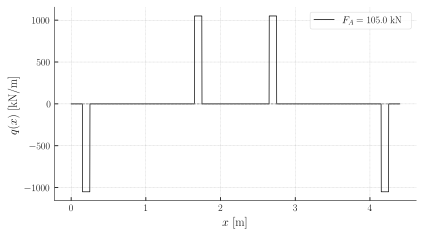

In [14]:
#| label: fig-q_x_sv14
#| fig-cap: Verlauf der Einwirkungen und Reaktionskräften
plt.plot(x_array, q_x_array[-1]/1000, color='black', label=f'$F_A =$ {Laststufen[-1]/1000} kN')
plt.plot(x_array, 0*x_array, color='gray', linestyle='dashed')

plt.xlabel(f'${sp.latex(x)}$ [m]')
plt.ylabel(f'${sp.latex(q_x)}$ [kN/m]')
plt.legend()
plt.savefig('../images/q_x_SV14.svg')

plt.show()


Durch Integration der Einwirkung resultiert der Querkraftverlauf.

$$
V(x) = -\int q(x) + c_1
$${#eq-vx_integriert}

Dabei kann mit der Randbedingun $V(0) = 0$ die Integrationskonstante ermittelt werden. Der Verlauf der Querkräfte ist in @fig-v_x dargestellt. Nach dem Auflager $B$ ist der Plattenstreifen unbelastet.

In [15]:
eq_V_x = sp.Eq(-V_x,sp.integrate(eq_q_x_num.rhs, x) + c_1)

c_1_num = sp.solve(eq_V_x.rhs.subs(x,0).subs(params),c_1)[0]

V_x_solve = eq_V_x.subs(c_1, c_1_num).simplify()

V_x_lamb = sp.lambdify((F_A,x),V_x_solve.rhs, 'numpy')

V_x_array =[]
for Last in Laststufen:
    V_x_array.append(V_x_lamb(Last,x_array))

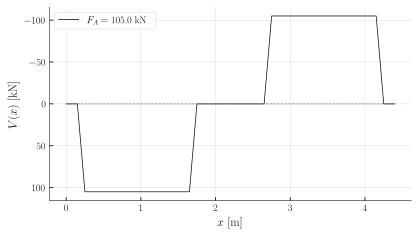

In [16]:
#| label: fig-v_x_sv14
#| fig-cap: Verlauf der Querkräfte 

plt.plot(x_array, V_x_array[-1]/1000, color='black', label=f'$F_A =$ {Laststufen[-1]/1000} kN')
plt.plot(x_array, 0*x_array, color='gray', linestyle='dashed')

plt.gca().invert_yaxis()
plt.xlabel(f'${sp.latex(x)}$ [m]')
plt.ylabel(f'${sp.latex(V_x)}$ [kN]')
plt.legend()
plt.savefig('../images/V_x_SV14.svg')

plt.show()


Der Verlauf der Biegemoment lässt sich durch Integration der Querkräfte bestimmen:


$$
M(x) = \int V(x) + c_2
$$

Dabei kann mit der Randbedingung $M(0) = 0$ die Integrationskonstante ermittelt werden. Der Verlauf der Biegemomente ist in @fig-m_x dargestellt. Es stellt sich ein Minimum über dem Auflager $C$ ein.

In [17]:
eq_M_x = sp.Eq(M_x, sp.integrate(V_x_solve.rhs,x)+c_2)
c_2_num = sp.solve(eq_M_x.subs(x,0).rhs.subs(params), c_2)[0]
M_x_solve = eq_M_x.subs(c_2, c_2_num).simplify()
M_x_lamb = sp.lambdify((F_A, x),M_x_solve.rhs, 'numpy')


M_x_array = []
for Last in Laststufen:
    M_x_array.append(M_x_lamb(Last, x_array))


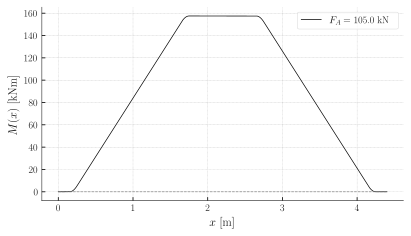

In [18]:
#| label: fig-m_x_sv14
#| fig-cap: Verlauf der Biegemomente 

plt.plot(x_array, M_x_array[-1]/1000, color='black', label=f'$F_A =$ {Laststufen[-1]/1000} kN')
plt.plot(x_array, 0*x_array, color='gray', linestyle='dashed')

plt.xlabel(f'${sp.latex(x)}$ [m]')
plt.ylabel(f'${sp.latex(M_x)}$ [kNm]')
plt.legend()
plt.savefig('../images/M_x_SV14.svg')

plt.show()

Neben den resultierenden Biegemomenten aus der Einwirkung kann ein Biegemoment, induziert durch die Längszukraft aus der Querkraft, ermittelt werden. Dies ist mit einem Versatzmass berücksichtigt. Dabei gilt das Versatzmass lediglich für die Längszugkraft. Multipliziert mit der statischen Höhe resultiert der Versatz des Biegemoments

$$
h_{versatz} = \frac{V \cdot \cot(\theta_{c3})}{2}
$${#eq-versatzmass}

$$
M_{versatz} = \frac{V \cdot \cot(\theta_{c3})}{2} \cdot z
$${#eq-versatzmment}

Der Momentenverlauf in @fig-m_x ist mit dem Versatzmass zu erhöhen. Dargestellt ist dies in @fig-m_x_versatz. Beim Momentenminimum bildet sich ein Plateau aus.



In [19]:
theta_c3 = 30 #in Grad

eq_d = sp.Eq(d,h - c_nom - sp.Rational(1.5) * diam_s)
eq_d_num = eq_d.subs(params)
Eq_list.append(eq_d_num)

h_versatz = abs(V_x)*sp.cot(sp.rad(theta_c3))/2 * eq_d_num.rhs.args[0]*0.9/1000



h_versatz_lamb = sp.lambdify((V_x), h_versatz, 'numpy')

h_versatz_array = []
for V_x in V_x_array:
    h_versatz_array.append(h_versatz_lamb(V_x))






In [20]:
def calculate_m_c_versatz(mx, versatz):
    
    mx_sol_list = []
    maximum = max(mx)
    for i in range(0,len(mx)):
        if (mx[i] + versatz[i]) >= maximum:
            mx_sol =  maximum
            
        else:
            mx_sol = mx[i]+versatz[i]
        mx_sol_list.append(mx_sol)
    
    return mx_sol_list
    
M_x_array_versatz = []
for i in range(0,len(M_x_array)):
    
    mx_versetzt = calculate_m_c_versatz(M_x_array[i], h_versatz_array[i])
    M_x_array_versatz.append(np.array(mx_versetzt))

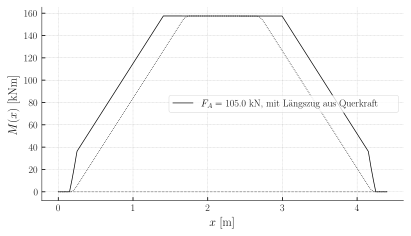

In [21]:
#| label: fig-m_x_versatz_sv14
#| fig-cap: Verlauf der Biegemomente mit Längszugkraft aus Querkraft
plt.plot(x_array, M_x_array[-1]/1000, color='black', linestyle='dotted')
plt.plot(x_array, M_x_array_versatz[-1]/1000, color='black', label=f'$F_A =$ {Laststufen[-1]/1000} kN, mit Längszug aus Querkraft')
plt.plot(x_array, 0*x_array, color='gray', linestyle='dashed')

plt.xlabel(f'${sp.latex(x)}$ [m]')
plt.ylabel(f'${sp.latex(M_x)}$ [kNm]')
plt.legend()
plt.savefig('../images/M_x_versatz_SV14.svg')

plt.show()

In [22]:
eq_phi_x = sp.Eq(phi_x, sp.integrate(M_x_solve.rhs/EI,x)+c_3)


#### Biegesteifigkeit - Vollständig ungerissen

Wie in @sec-kontinua hergeleitet, sind die Gleichgewichtsbetrachtungen nicht ausreichend um die Verdrehung und Verformung zu beschreiben. Die Werkstoffbeziehung bedingt eine Biegesteifigkeit. Dabei wird von einer konstanten Biegesteifigkeit ausgegangen. Für einen ungerissenen Querschnitts folgt diese zu:

In [23]:
eq_EI = sp.Eq(EI, E_c * b*h**3/12)
eq_EI_num = eq_EI.subs(params)
Eq_list.append(eq_EI_num)


In [24]:
display(eq_EI, unit.convert_to(eq_EI_num.evalf(3), [unit.kilonewton, unit.meter]))

            3
     E_c⋅b⋅h 
EI = ────────
        12   

                            2
EI = 4.9e+4⋅kilonewton⋅meter 

Der Verlauf der Verdrehung entspricht dem Integrierten Verlauf der Biegemomente, dividiert durch die Biegesteifigkeit.

$$
\varphi(x) = \frac{1}{EI}\int M(x) + c_3
$${#eq-verdrehung}

Abschliessend lässt sich die Verformung anhand der Verdrehung ermitteln.

$$
w(x) = \int -\varphi(x) + c_4
$${#eq-verformung}


Mit den Randbedingungen $w(C) = 0$ und $w(B) = 0$ sind die Integrationskonstanten bestimmt. Die elastische Verformung für einen ungerissenen Querschnitt ist in @fig-w_x dargestellt. 



In [25]:
eq_w_x = sp.Eq(w_x, -sp.integrate(eq_phi_x.rhs, x)+ c_4)
eq_w_x.subs(params_plot)
c_solve = sp.solve([eq_w_x.rhs.subs(x,a_1).subs(params_plot), eq_w_x.rhs.subs(x,a_1 + a_2+a_3 + a_4).subs(params_plot)],[c_3, c_4])


eq_w_x_solve = eq_w_x.subs(c_solve).subs(params_plot)


w_x_lamb = sp.lambdify((F_A,x, EI),eq_w_x_solve.rhs)

In [26]:
w_x_array_ungerissen = []
for Last in Laststufen:
    w_x_array_ungerissen.append(w_x_lamb(Last, x_array, np.float64(eq_EI.rhs.subs(params_plot))))



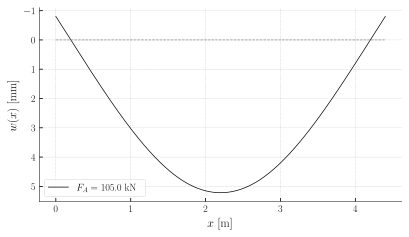

In [27]:
#| label: fig-w_x_sv14
#| fig-cap: Verlauf der Verformung für eine konstante ungerissene Biegesteifigkeit

plt.plot(x_array, w_x_array_ungerissen[-1]*1000, color='black', label=f'$F_A =$ {Laststufen[-1]/1000} kN')
plt.plot(x_array, 0*x_array, color='gray', linestyle='dashed')
plt.gca().invert_yaxis()
plt.xlabel(f'${sp.latex(x)}$ [m]')
plt.ylabel(f'${sp.latex(w_x)}$ [mm]')
plt.legend()
plt.savefig('../images/w_x_SV14.svg')

plt.show()

In [28]:
w_1_elastisch_ungerissen = []
for Last in Laststufen:
    w_1_elastisch_ungerissen.append(w_x_lamb(Last, 2.2, np.float64(eq_EI.rhs.subs(params_plot))))
eq_w_1_elastisch = sp.Eq(w_1,unit.convert_to(w_1_elastisch_ungerissen[-1]*unit.m,unit.mm))


Eq_list.append(eq_w_1_elastisch)


## Mohrsche Analogie

Das Vorgehen ist in @sec-mohrsche_analogie beschrieben. Der bereits bestimmte Momentenverlauf gemäss @fig-m_x, dividiert durch die ungerissene Biegesteifigkeit, ist als Einwirkung auf das System anzusetzen. Dargestellt ist dies in @fig-q_x_mohr.

In [29]:
eq_q_x_mohr = sp.Eq(q_x_a, M_x_solve.rhs / EI)
eq_q_x_mohr_num = eq_subs(eq_q_x_mohr, eq_EI).subs(params_plot)
q_x_mohr_lamb = sp.lambdify((F_A, x), eq_q_x_mohr_num.rhs, 'numpy')

In [30]:
q_x_mohr_array =[]
for Last in Laststufen:
    q_x_mohr_array.append(q_x_mohr_lamb(Last, x_array))
    
    
    

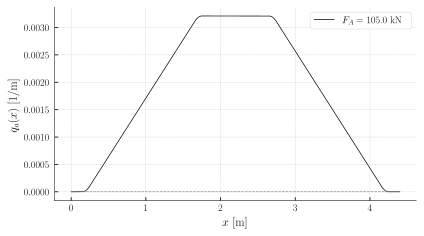

In [31]:
#| label: fig-q_x_mohr_sv14
#| fig-cap: Verlauf der Einwirkungen auf das analoge System
plt.plot(x_array, q_x_mohr_array[-1], color='black', label=f'$F_A =$ {Laststufen[-1]/1000} kN')
plt.plot(x_array, 0*x_array, color='gray', linestyle='dashed')

plt.xlabel(f'${sp.latex(x)}$ [m]')
plt.ylabel(f'${sp.latex(q_x_a)}$ [1/m]')
plt.legend()
plt.savefig('../images/q_x_mohr_SV14.svg')

plt.show()

Die maximale Biegeverformung tritt beim Stabanfang auf. Gemäss der @fig-w_x ist bekannt, dass bei den Auflagerpunkten die Verformung gleich null sein muss, sowie die Verformung am Stabanfang und einen Maximalwert aufweist. Die Verformung bei der Mohrschen Analogie entspricht dem Biegemomentenverlauf des analogen Systems. Folglich ist bei den Stab Anfangs- und Endpunkten eine volle Einspannung zu modellieren, sowie bei den Auflagerpunkten ein Biegegelenk einzuführen. Dies deckt sich mit den Lagerungsbedingungen aus @fig-randbedingungen_analogiesysteme.



In [32]:
eq_V_x_mohr = sp.Eq(V_x_a, -sp.integrate(eq_q_x_mohr_num.rhs, x)+c_1)
eq_M_x_mohr = sp.Eq(M_x_a, sp.integrate(eq_V_x_mohr.rhs, x)+c_2)
randbedingung_1 = sp.Eq(eq_M_x_mohr.rhs.subs(x, a_1),0).subs(params_plot)
randbedingung_2 = sp.Eq(eq_M_x_mohr.rhs.subs(x, a_1 +a_2+a_3 +a_4),0).subs(params_plot)

c_a_solve = sp.solve([randbedingung_1, randbedingung_2],[c_1,c_2])
c_a_solve
eq_V_x_mohr_subs = eq_V_x_mohr.subs(c_a_solve)
eq_M_x_mohr_subs = eq_M_x_mohr.subs(c_a_solve)


V_x_mohr_lamb = sp.lambdify((F_A,x), eq_V_x_mohr_subs.rhs, 'numpy')
M_x_mohr_lamb = sp.lambdify((F_A,x), eq_M_x_mohr_subs.rhs, 'numpy')

In [33]:
V_x_mohr_array =[]
M_x_mohr_array =[]
for Last in Laststufen:
    V_x_mohr_array.append(V_x_mohr_lamb(Last,x_array))
    M_x_mohr_array.append(M_x_mohr_lamb(Last,x_array))

Der Querkraftverlauf für das analoge Sytem ist in @fig-v_x_mohr aufgezeigt. Die Querkraft ist einheitslos, da es sich um die Verdrehung handelt.

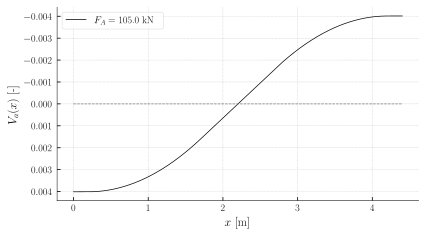

In [34]:
#| label: fig-v_x_mohr_sv14
#| fig-cap: Verlauf der Querkräfte für das Analogiesystem

plt.plot(x_array, V_x_mohr_array[-1], color='black', label=f'$F_A =$ {Laststufen[-1]/1000} kN')
plt.plot(x_array, 0*x_array, color='gray', linestyle='dashed')

plt.gca().invert_yaxis()
plt.xlabel(f'${sp.latex(x)}$ [m]')
plt.ylabel(f'${sp.latex(V_x_a)}$ [-]')
plt.legend()
plt.savefig('../images/V_x_mohr_SV14.svg')

plt.show()


Der Biegemomentenverlauf für das analoge System zeigt die @fig-m_x_mohr. Der Momentenverlauf entspricht der Verformung und ist folglich in [mm] dargestellt.

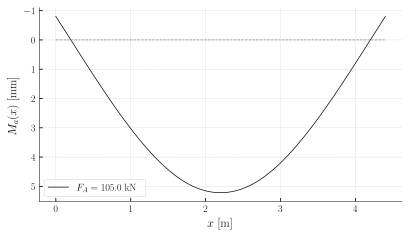

In [35]:
#| label: fig-m_x_mohr_sv14
#| fig-cap: Verlauf der Biegemomente für das Analogiesystem

plt.plot(x_array, M_x_mohr_array[-1]*1000, color='black', label=f'$F_A =$ {Laststufen[-1]/1000} kN')
plt.plot(x_array, 0*x_array, color='gray', linestyle='dashed')

plt.gca().invert_yaxis()
plt.xlabel(f'${sp.latex(x)}$ [m]')
plt.ylabel(f'${sp.latex(M_x_a)}$ [mm]')
plt.legend()
plt.savefig('../images/w_x_mohr_SV14.svg')

plt.show()

## Abschätzung nach Norm
Nach der bestimmten elastischen Verformung kann die Verformung anhand des vollständig gerissenen Querschnitts nach @SIA2013a ermittelt werden. Ohne Druckbewehrung und Kriecheinflüsse folgt die Gleichung zu:


$$
w_{1II,SIA} = \frac{0.75}{10\rho^{0.7}}\left(\frac{h}{d}\right)^3 w_1
$${#eq-w_1_II_sia}

Dabei entspricht der geometrische Bewehrungsgehalt:

In [36]:
eq_rho = sp.Eq(rho, A_s/(b*d))
Eq_list.append(eq_rho)
display(eq_rho)

     Aₛ
ρ = ───
    b⋅d

Vereinfacht wird der Stab in der Mitte der Zugzone der Querschnittsfläche hinzugezählt, unter Berücksichtigung der kleineren Fliessgrenze. Die Querschnittsfläche der Stäbe im Zugbereich folgt zu:

In [37]:
eq_A_s = sp.Eq(A_s, sp.Mul(2,sp.pi * diam_s **2 / (4) + sp.pi*diam_s550**2/4 * f_s550/f_sy, evaluate=False))
eq_A_s_num = unit.convert_to(eq_A_s.subs(params), unit.mm)
Eq_list.append(eq_A_s_num)
display(eq_A_s, eq_A_s_num.evalf(4))

       ⎛          2                  2      ⎞
       ⎜π⋅\oslashₛ    π⋅\oslash_s,550 ⋅fₛ₅₅₀⎟
Aₛ = 2⋅⎜─────────── + ──────────────────────⎟
       ⎝     4                4⋅f_sy        ⎠

                     2
Aₛ = 694.6⋅millimeter 

Die statische Höhe ist definiert gemäss:

In [38]:
eq_d = sp.Eq(d,h - c_nom - sp.Rational(1.5) * diam_s)
eq_d_num = eq_d.subs(params)
Eq_list.append(eq_d_num)
display(eq_d, eq_d_num.evalf(3))


      3⋅\oslashₛ           
d = - ────────── - cₙₒₘ + h
          2                

d = 379.0⋅millimeter

Die Verformung entspricht abschliessend:

In [39]:
eq_w_1_gerissen_norm = sp.Eq(w_1_gerissen_norm, sp.Mul(0.75/(10*rho)**sp.Rational(0.7) , (h/d)**3 * w_1, evaluate=False))
eq_w_1_gerissen_norm_num = unit.convert_to(eq_subs(eq_w_1_gerissen_norm, *Eq_list).subs(params), unit.mm)
Eq_list.append(eq_w_1_gerissen_norm_num)

w_1_gerissen_norm_lamb = sp.lambdify((w_1),eq_w_1_gerissen_norm.rhs.subs(rho, eq_rho.rhs).subs(d, eq_d_num.rhs.args[0]).subs(A_s, eq_A_s_num.rhs).subs(params).subs(unit.mm,1), 'numpy')

display(eq_w_1_gerissen_norm_num.evalf(3))

w_1_II,SIA = 31.1⋅millimeter

## Numerische Integration der Krümmung


### Grundlagen

Um sich von der Betrachtung einer konstanten Biegesteifigkeit zu lösen, hilft die Anwendung einer verfeinerten Momenten-Krümmungsbeziehung. Folgend wird ein Momentenkrümmungsdiagramm für den Querschnitt aus dem beschriebenen Versuch berechnet. Die vorhandene Querkraftbewehrung ist nicht dargestellt in @fig-qs_a3.


![Querschnitt des Versuchs A3 zur Bestimmung des Momenten-Krümmungdiagramms](../images/QS_Versuch14.svg){#fig-qs_sv14}


Vereinfacht wird der Querschnitt folgender massen:


![Vereinfachung der Bewehrungsführung](../images/QS_14.svg){#fig-qs_sv14_vereinfachung}

Die Parameter in @tbl-params_krummung finden Einfluss in die Berechnungen.

In [40]:
#| label: tbl-params_krummung
#| tbl-cap: Versuchsparameter für die verfeinerte Momenten-Krümmungsbeziehung


dict_to_table(params_krummung)

|   |   |
|---|---|
| $E_{c} = 38000.0 \, \frac{\text{N}}{\text{mm}^{2}}$ | $E_{s} = 200000.0 \, \frac{\text{N}}{\text{mm}^{2}}$ |
| $\oslash_{s} = 18.0 \, \text{mm}$ | $\oslash_{s,550} = 12.0 \, \text{mm}$ |
| $c_{nom} = 44.0 \, \text{mm}$ | $f_{c} = 35 \, \frac{\text{N}}{\text{mm}^{2}}$ |
| $f_{ct} = 4.0 \, \frac{\text{N}}{\text{mm}^{2}}$ | $f_{s550} = 550.0 \, \frac{\text{N}}{\text{mm}^{2}}$ |
| $f_{su} = 800 \, \frac{\text{N}}{\text{mm}^{2}}$ | $f_{sy} = 670.0 \, \frac{\text{N}}{\text{mm}^{2}}$ |
| $\varepsilon_{cu} = 0.003$ | $\varepsilon_{su} = 0.05$ |


Neben den Parametern wird das Stoffgesetz für den Betonstahl in @fig-stahlkennlinie hinterlegt. Das Bilineare, bzw. linear-elastisch linear-plastische Spannungs-Dehnungsdiagramm für den Betonstahl hält den Rechenaufwand klein und liefert eine ausreichende Genauigkeit. Eine Berücksichtigung des verfestigenden Verhaltens ist essentiell um die Verformungen nach dem Fliessen des Betonstahls näherungsweise zu bestimmen. Das Diagramm ist definiert bis zur Bruchdehnung des Stahls. Das Verhalten gilt ebenso im negativen Spannungs-Dehnungs Bereich.

In [41]:
eq_1 = sp.Eq(f_sy, a +b*f_sy/E_s)
eq_2 = sp.Eq(f_su, a + b*epsilon_su)



eq_lin = sp.Eq(sigma_epsilon_s, a + b * epsilon_s).subs(sp.solve([eq_1,eq_2],[a,b]))

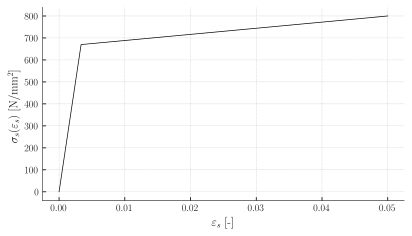

In [42]:
#| label: fig-stahlkennlinie_sv14
#| fig-cap: Spannungs-Dehnungs Diagramm des Bewehrungsstahls linear elastisch-linear verfestigend plastisch


eq_sigma_epsilon_s = sp.Eq(sigma_epsilon_s, sp.Piecewise(
    (E_s * epsilon_s, (epsilon_s<=f_sy / E_s)&(epsilon_s>=0)),
    (eq_lin.rhs.subs(params_plot), (epsilon_s<=epsilon_su)&(epsilon_s>=f_sy / E_s))
    ))




eq_sigma_epsilon_s_num = eq_sigma_epsilon_s.subs(params_plot) 

eq_sigma_epsilon_s_lamb = sp.lambdify((epsilon_s),eq_sigma_epsilon_s_num.rhs)


epsilon_s_array = np.linspace(0, np.float64(epsilon_su.subs(params_plot)), 2000)
eq_sigma_epsilon_array = eq_sigma_epsilon_s_lamb(epsilon_s_array)


plt.plot(epsilon_s_array, eq_sigma_epsilon_array/1000**2, color='black')

plt.xlabel(f'${sp.latex(epsilon_s)}$ [-]')
plt.ylabel(f'${sp.latex(sigma_epsilon_s)}$ [N/mm$ ^2$]')
plt.savefig('../images/spannung_dehnung_stahl_SV14.svg')

plt.show()

In [43]:
eq_sigma_epsilon_c = sp.Eq(sigma_epsilon_c,sp.Piecewise((E_c * epsilon_c, (epsilon_c <=f_ct/E_c)&(epsilon_c >-f_c/E_c)), (-f_c, epsilon_c< -f_c/E_c)))


eq_sigma_epsilon_c_num = eq_sigma_epsilon_c.subs(params_plot)



Die Betonkennlinie in @fig-betonkennlinie zeigt ein linear-elastisches ideal-plastisches verhalten. Im positiven Bereich lässt sich die Betonspannung bis zur Betonzugfestigkeit erhöhen, im negativen Spannungsbereich beginnt ein Plastifizieren beim Erreichen der Betondruckfestigkeit. Bis zur Bruchstauchung ist dies definiert.

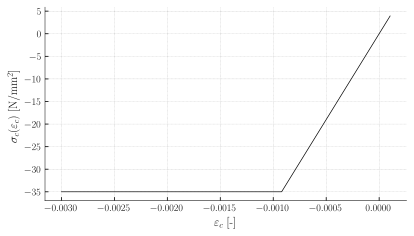

In [44]:
#| label: fig-betonkennlinie_sv14
#| fig-cap: Spannungs-Dehnungs Diagramm des Betons linear elastisch-ideal plastisch


eq_sigma_epsilon_c_lamb = sp.lambdify((epsilon_c),eq_sigma_epsilon_c_num.rhs)


epsilon_c_array = np.linspace(-np.float64(epsilon_cu.subs(params_plot)), np.float64(epsilon_cu.subs(params_plot)), 2000)
eq_sigma_epsilon_c_array = eq_sigma_epsilon_c_lamb(epsilon_c_array)


plt.plot(epsilon_c_array, eq_sigma_epsilon_c_array/1000**2, color='black')

plt.xlabel(f'${sp.latex(epsilon_c)}$ [-]')
plt.ylabel(f'${sp.latex(sigma_epsilon_c)}$ [N/mm$ ^2$]')
plt.savefig('../images/spannung_dehnung_beton_SV14.svg')

plt.show()

### Querschnittsanalyse

Mittels einer Querschnittsanalyse lassen sich die unterschiedlichen Zustände des Momenten-Krümmungdiagramms ermitteln.

#### Schwerpunkt des Querschnitts

Durch die Bestimmung der Wertigkeit $n$ kann der Querschnitt als homogener Betonquerschnitt zur Bestimmung des Schwerpunkts behandelt werden.

In [45]:
eq_n = sp.Eq(n, E_s / E_c)
eq_n_num = eq_n.subs(params)
Eq_list.append(eq_n_num)



display(eq_n,eq_n_num.evalf(3))

     Eₛ
n = ───
    E_c

n = 5.26

Die Querschnittsfläche der Bewehrung beträgt:

In [46]:


display(eq_A_s, eq_A_s_num.evalf(4))

       ⎛          2                  2      ⎞
       ⎜π⋅\oslashₛ    π⋅\oslash_s,550 ⋅fₛ₅₅₀⎟
Aₛ = 2⋅⎜─────────── + ──────────────────────⎟
       ⎝     4                4⋅f_sy        ⎠

                     2
Aₛ = 694.6⋅millimeter 

Die Betonquerschnittsfläche:

In [47]:
eq_A_c = sp.Eq(A_c, b*h)
eq_A_c_num = unit.convert_to(eq_A_c.subs(params), unit.mm)

Eq_list.append(eq_A_c_num)

display(eq_A_c, eq_A_c_num)

A_c = b⋅h

                        2
A_c = 76500.0⋅millimeter 

Die ideelle Querschnittsfläche resultiert zu:

In [48]:
eq_Ai = sp.Eq(A_i, A_c + A_s *(n-1))
eq_Ai_num = unit.convert_to(eq_subs(eq_Ai, *Eq_list), unit.mm)

Eq_list.append(eq_Ai_num)

display(eq_Ai,eq_Ai_num.evalf(6))

Aᵢ = A_c + Aₛ⋅(n - 1)

                       2
Aᵢ = 79461.3⋅millimeter 

Und die z-Koordinate des Schwerpunkts folgt abschliessend zu:

In [49]:
eq_zeta_c = sp.Eq(zeta_c, sp.Mul(1/A_i,A_c * h/2 + A_s*(n-1) * (c_nom +1.5*diam_s), evaluate=False))
eq_zeta_c_num = unit.convert_to(eq_subs(eq_zeta_c, *Eq_list).subs(params), unit.mm)

Eq_list.append(eq_zeta_c_num)
display(eq_zeta_c, eq_zeta_c_num.simplify().evalf(3))

      A_c⋅h                                   
      ───── + Aₛ⋅(1.5⋅\oslashₛ + cₙₒₘ)⋅(n - 1)
        2                                     
ζ_c = ────────────────────────────────────────
                         Aᵢ                   

ζ_c = 219.0⋅millimeter

In [50]:
unit.convert_to(eq_A_s_num.evalf(3),unit.cm)

                    2
Aₛ = 6.95⋅centimeter 

#### Flächenträgheitsmoment

Das Flächenträgheitsmoment wird ebenfalls am ideellen Querschnitt bestimmt. Die Eigenträgheitsmomente der Kreisquerschnitte der Bewehrung sind nicht berücksichtigt, lediglich der Steiner-Anteil fliesst in die Berechnung ein:

In [51]:
eq_I_1 = sp.Eq(I_1, b * h**3/12 +b*h*(h/2 - zeta_c)**2 + A_s * (n-1) * (c_nom + sp.Rational(1.5)*diam_s - zeta_c)**2)
eq_I_1_num = unit.convert_to(eq_subs(eq_I_1, *Eq_list).subs(params), unit.mm)

Eq_list.append(eq_I_1_num)
display(eq_I_1, eq_I_1_num.evalf(3))


                                           2      3                2
                  ⎛3⋅\oslashₛ             ⎞    b⋅h        ⎛h      ⎞ 
I__I = Aₛ⋅(n - 1)⋅⎜────────── + cₙₒₘ - ζ_c⎟  + ──── + b⋅h⋅⎜─ - ζ_c⎟ 
                  ⎝    2                  ⎠     12        ⎝2      ⎠ 

                         4
I__I = 1.36e+9⋅millimeter 

#### Ungerissen - Zustand 1

Der Querschnitt verbleibt elastisch. Folglich kann das Flächenträgheitsmoment mit $E_c$ multipliziert werden und es resultiert die ungerissene Biegesteifigkeit:

In [52]:
eq_EI_1 = sp.Eq(EI_I, I_1 * E_c)
eq_EI_I_num = eq_subs(eq_EI_1, *Eq_list).subs(params)

Eq_list.append(eq_EI_I_num)


In [53]:

display(eq_EI_1, unit.convert_to(eq_EI_I_num.evalf(4),[unit.kilonewton, unit.meter]))

EI__I = E_c⋅I__I

                                 2
EI__I = 5.163e+4⋅kilonewton⋅meter 

##### Rissmoment

Durch die Ermittlung des Rissmoments kann die Krümmung vor dem Reissen des Betons ermittelt werden. Die Betonzugkraft wird nicht berücksichtigt.

![Querschnittsanalyse vor dem Reissen des Betons](../images/QS_14_analyse_5.svg){#fig-qs2_sv14}


Die Betondruckspannung beträgt:

In [54]:
eq_sigma_c_inf1 = sp.Eq(sigma_c_inf_1,f_ct / zeta_c * (h-zeta_c))
eq_sigma_c_inf1_num = unit.convert_to(eq_subs(eq_sigma_c_inf1,*Eq_list).subs(params),unit.mm)

Eq_list.append(eq_sigma_c_inf1_num)
display(eq_sigma_c_inf1, eq_sigma_c_inf1_num.evalf(3))


            f_ct⋅(h - ζ_c)
σ_c_inf,1 = ──────────────
                 ζ_c      

            4.21⋅newton
σ_c_inf,1 = ───────────
                      2
            millimeter 

Der Hebelarm der inneren Kräfte folgt zu:

In [55]:
eq_z_r = sp.Eq(z_1, h - ((h-zeta_c)/3 + c_nom + 3/2 * diam_s))
eq_z_r_num = unit.convert_to(eq_subs(eq_z_r, *Eq_list).subs(params), unit.mm)
Eq_list.append(eq_z_r_num)
display(eq_z_r, eq_z_r_num.evalf(3))

                            2⋅h   ζ_c
z₁ = -1.5⋅\oslashₛ - cₙₒₘ + ─── + ───
                             3     3 

z₁ = 302.0⋅millimeter

Die Betondruckkraft ist definiert nach:

In [56]:
eq_F_c_r = sp.Eq(F_c1,  sigma_c_inf_1 * b * (h-zeta_c)/2)
eq_F_c_r_num = eq_subs(eq_F_c_r, *Eq_list).subs(params)

Eq_list.append(eq_F_c_r_num)
display(eq_F_c_r, unit.convert_to(eq_F_c_r_num.evalf(3), unit.kilonewton))


        b⋅σ_c_inf,1⋅(h - ζ_c)
F_c,1 = ─────────────────────
                  2          

F_c,1 = 82.6⋅kilonewton

Und das Rissmoment resultiert schliesslich zu:

In [57]:
eq_M_r = sp.Eq(M_r, F_c1 * z_1)
eq_M_r_num = eq_subs(eq_M_r, *Eq_list)
Eq_list.append(eq_M_r_num)


In [58]:

display(eq_M_r, unit.convert_to(eq_M_r_num.evalf(4), [unit.kilonewton, unit.meter]))

Mᵣ = F_c,1⋅z₁

Mᵣ = 24.94⋅kilonewton⋅meter

Aus dem Rissmoment folgt die Krümmung beim Reissen:

In [59]:
eq_chi_r = sp.Eq(chi_r, M_r / (EI_I))
eq_chi_r_num = unit.convert_to(eq_subs(eq_chi_r, *Eq_list), unit.m)

Eq_list.append(eq_chi_r_num)
display(eq_chi_r,eq_chi_r_num.evalf(3))

       Mᵣ 
χᵣ = ─────
     EI__I

     0.000483
χᵣ = ────────
      meter  

Die Neigung linearen Funktion des ungerissenen Zustands im Momentenkrümmungsdiagramm ist durch die Biegesteifigkeit definiert. Der Endpunkts des Zustand 1 definiert das Rissmoment mit der entsprechenden Krümmung.

#### Gerissen Elastisch - Zustand 2

Der Querschnitt nach dem Reissen ist in @fig-qs3 dargestellt. Der Betonstahl hat die Fliessgrenze noch nicht erreicht. Der Beton die Druckfestigkeit ebenfalls nicht.

![Querschnittsanalyse nach dem Reissen des Betons](../images/QS_14_analyse_4.svg){#fig-qs3_sv14}

Dabei beträgt die statische Höhe:

In [60]:

display(eq_d, eq_d_num)

      3⋅\oslashₛ           
d = - ────────── - cₙₒₘ + h
          2                

d = 379.0⋅millimeter

Mittels Gleichgewicht der Kräfte lässt sich die Betondruckzonenhöhe und folglich die gerissene Biegesteifigkeit herleiten. Die Betonstahlzugkraft beträgt:




In [61]:
eq_F_z2 = sp.Eq(F_z2, sigma_s2*A_s)
Eq_list.append(eq_F_z2)
display(eq_F_z2)


F_z,2 = Aₛ⋅σ_s,2

Die Betonstahlspannung für linear elastisches Verhalten folgt zu:

In [62]:
eq_sigma_s2 = sp.Eq(sigma_s2, epsilon_s2 * E_s)
Eq_list.append(eq_sigma_s2)
eq_sigma_s2

σ_s,2 = Eₛ⋅varepsilon_s,2

Die Betondruckkraft anhand des dreieckigen Verlaufs in @fig-qs3 beträgt:


In [63]:
eq_F_c2 = sp.Eq(F_c2, sigma_c_inf_2 * b * x_2 /2)
Eq_list.append(eq_F_c2)
eq_F_c2


        b⋅σ_c_inf,2⋅x₂
F_c,2 = ──────────────
              2       

Die Betonspannung ebenfalls bestimmt durch ein linear elastisches Verhalten ist definiert durch:

In [64]:
eq_sigma_c_inf2 = sp.Eq(sigma_c_inf_2, epsilon_c2* E_c)
Eq_list.append(eq_sigma_c_inf2)
eq_sigma_c_inf2

σ_c_inf,2 = E_c⋅varepsilon_c,2

Die Betondehnung anhand des Dehnungsverlaufs in @fig-qs3:

In [65]:
eq_epsilon_c2 = sp.Eq(epsilon_c2, epsilon_s2 /(d-x_2) * x_2)
Eq_list.append(eq_epsilon_c2)
eq_epsilon_c2

                 varepsilon_s,2⋅x₂
varepsilon_c,2 = ─────────────────
                       d - x₂     

Unter Bemühung des Gleichgewichts der horizontalen Kräfte lässt sich die folgende Beziehung ermitteln.

In [66]:
eq_ggw_1 = sp.Eq(F_c2, F_z2)
Eq_list.append(eq_ggw_1)
eq_ggw_1

F_c,2 = F_z,2

Einsetzen der bestimmten Gleichungen in die Gleichgewichtsbeziehung und mit $n$ und $\rho$ substituiert, folgt:

In [67]:

display(eq_n, eq_rho)

     Eₛ
n = ───
    E_c

     Aₛ
ρ = ───
    b⋅d

In [68]:
eq_ggw_1_subs = eq_subs(eq_F_c2,eq_sigma_c_inf2, eq_epsilon_c2, eq_ggw_1, eq_F_z2).subs(E_c, E_s/n).subs(sigma_s2, epsilon_s2 * E_s).subs(A_s, rho*b*d).simplify()
eq_ggw_1_subs

                                                2
                          Eₛ⋅b⋅varepsilon_s,2⋅x₂ 
Eₛ⋅b⋅d⋅ρ⋅varepsilon_s,2 = ───────────────────────
                                2⋅n⋅(d - x₂)     

Durch die Auflösung nach $x$ folgt die Betondruckzonenhöhe:

In [69]:
eq_x_2 = sp.Eq(x_2,sp.solve(eq_ggw_1_subs, x_2)[0])
eq_x_2_num = unit.convert_to(eq_subs(eq_x_2, *Eq_list).subs(params),unit.mm)
Eq_list.append(eq_x_2)
display(eq_x_2, eq_x_2_num.evalf(3))

       ⎛         _______________⎞
x₂ = d⋅⎝-n⋅ρ + ╲╱ n⋅ρ⋅(n⋅ρ + 2) ⎠

x₂ = 108.0⋅millimeter

Zur Bestimmung der Krümmung ist die Betonstahldehnung erforderlich. Diese bedingt ein einwirkendes Moment. Der Übergang zwischen ungerissenem zu gerissenem Verhalten erfolgt beim Rissmoment. Folglich kann das Rissmoment in @fig-qs3 angesetzt werden.

In [70]:
eq_M_2 = sp.Eq(M_2, F_z2 * (d-x_2/3))
eq_M_2_M_r = sp.Eq(M_2, M_r)
Eq_list.append(eq_M_2)
Eq_list.append(eq_M_2_M_r)

display(eq_M_2,eq_M_2_M_r, eq_subs(eq_M_2,eq_M_2_M_r, eq_F_z2, eq_sigma_s2))

           ⎛    x₂⎞
M₂ = F_z,2⋅⎜d - ──⎟
           ⎝    3 ⎠

M₂ = Mᵣ

                          ⎛    x₂⎞
Mᵣ = Aₛ⋅Eₛ⋅varepsilon_s,2⋅⎜d - ──⎟
                          ⎝    3 ⎠

Daraus resultiert die Betonstahldehnung:

In [71]:
eq_epsilon_s2 = sp.Eq(epsilon_s2,sp.solve(eq_subs(eq_M_2, eq_x_2, eq_sigma_s2, eq_F_z2, eq_M_2_M_r), epsilon_s2)[0])

eq_epsilon_s2_num = eq_subs(eq_epsilon_s2, *Eq_list).subs(params)
Eq_list.append(eq_epsilon_s2_num)


display(eq_epsilon_s2_num.evalf(3))

varepsilon_s,2 = 0.000524

Die Krümmung kann anhand des Dehnungsverlaufs in @fig-qs3 bestimmt werden:

In [72]:
eq_chi_II = sp.Eq(chi_II, epsilon_s2/(d-x_2))
eq_chi_II_num = unit.convert_to(eq_subs(eq_chi_II, eq_x_2_num, eq_d_num, eq_epsilon_s2_num).simplify(), unit.m)
Eq_list.append(eq_chi_II)

display(eq_chi_II,eq_chi_II_num.evalf(3))


             varepsilon_s,2
\chi__{II} = ──────────────
                 d - x₂    

             0.00193
\chi__{II} = ───────
              meter 

Abschliessend folgt die gerissene Biegesteifigkeit zu:

In [73]:

eq_EI_II = sp.Eq(EI_II, M_2 / chi_II)
eq_EI_II_num = eq_subs(eq_EI_II, *Eq_list).subs(params).simplify()
Eq_list.append(eq_EI_II_num)


In [74]:
display(eq_EI_II, unit.convert_to(eq_EI_II_num.evalf(6), [unit.kilonewton, unit.meter]))



               M₂    
EI__{II} = ──────────
           \chi__{II}

                                   2
EI__{II} = 12915.3⋅kilonewton⋅meter 

Die Neigung der linearen Funktion im gerissenen Bereich ist durch die gerissene Biegesteifigkeit definiert. Der Beginn ist durch das Rissmoment definiert.

#### Fliessen der Bewehrung - Zustand 3

Die Biegesteifigkeit $EI^{II}$ gilt bis die Bewehrung fliesst oder der Beton beginnt zu plastifizieren. In @fig-qs4 wird vorausgesetzt, dass die Bewehrung fliesst.

![Querschnittsanalyse für reine Biegung beim Fliessen der Bewehrung](../images/QS_14_analyse_2.svg){#fig-qs4_sv14}

Durch Gleichgewicht der horizontalen Kräfte folgen die Beziehungen:

In [75]:
eq_sigma_c_inf3 = sp.Eq(sigma_c_inf_3,f_sy / E_s / (d-x_3) *x_3 * E_c)
eq_ggw_fliessen = sp.Eq(A_s * f_sy, x_3 * b * sigma_c_inf_3/2)
display(eq_sigma_c_inf3,eq_ggw_fliessen)

            E_c⋅f_sy⋅x₃
σ_c_inf,3 = ───────────
            Eₛ⋅(d - x₃)

          b⋅σ_c_inf,3⋅x₃
Aₛ⋅f_sy = ──────────────
                2       

Aufgelöst nach der Druckzonenhöhe:

In [76]:
eq_x_3 = sp.Eq(x_3,sp.solve(eq_subs(eq_ggw_fliessen, eq_sigma_c_inf3), x_3)[1])
eq_x_3_num = unit.convert_to(eq_subs(eq_x_3, *Eq_list).subs(params), unit.mm).simplify()
Eq_list.append(eq_x_3)

display(eq_x_3, eq_x_3_num.evalf(3))

                ___________________________
     -Aₛ⋅Eₛ + ╲╱ Aₛ⋅Eₛ⋅(Aₛ⋅Eₛ + 2⋅E_c⋅b⋅d) 
x₃ = ──────────────────────────────────────
                     E_c⋅b                 

x₃ = 108.0⋅millimeter

Daraus lässt sich das Fliessmoment bestimmen, welches den Endpunkt im Momenten-Krümmungsdiagramm für den gerissenen Zustand definiert:

In [77]:
eq_M_y = sp.Eq(M_y, A_s * f_sy * (d-x_3/3))
eq_M_y_num =  eq_subs(eq_M_y, *Eq_list).subs(params).simplify()
display(eq_M_y, unit.convert_to(eq_M_y_num.evalf(4), [unit.kilonewton, unit.meter]))

              ⎛    x₃⎞
M_y = Aₛ⋅f_sy⋅⎜d - ──⎟
              ⎝    3 ⎠

M_y = 159.6⋅kilonewton⋅meter

Die Fliessdehnung des Betonstahls entspricht:

In [78]:
eq_epsilon_sy = sp.Eq(epsilon_sy, f_sy / E_s)

Eq_list.append(eq_epsilon_sy)

eq_epsilon_sy.subs(params)

varepsilon_sy = 0.00335

Abschliessend lässt sich die Krümmung für den Endpunkt des Zustands 2 folgend bestimmen:

In [79]:
eq_chi_y = sp.Eq(chi_y, epsilon_sy / (d-x_3))


In [80]:

eq_chi_y_num = eq_subs(eq_chi_y, *Eq_list).subs(params).simplify()
Eq_list.append(eq_chi_y_num)
display(eq_chi_y, unit.convert_to(eq_chi_y_num.evalf(3), unit.meter))

         varepsilon_sy
\chi_y = ─────────────
             d - x₃   

         0.0124
\chi_y = ──────
         meter 

Der Zustand 3 beschreibt lediglich den Endpunkt des gerissenen Bereichs im Momenten-Krümmungsdiagramm.

#### Maximaler Biegewiderstand - Zustand 4

Abschliessen kann der maximale Biegewiderstand durch die plastifizierung der Betondruckzone bestimmt werden. Vereinfacht wird dem Betonstahl die statische Zugfestigkeit vorausgesetzt um das verfestigende Verhalten annähernd abzubilden. Dies bedingt grundsätzlich das Erreichen der Bruchdehnung im Stahl. Da der Querschnitt stark bewehrt ist, versagt die Betondruckzone vor dem Erreichen der Betonstahlbruchdehnung.

![Querschnittsanalyse für reine Biegung mit der Bewehrung bei der Bruchspannung und plastifizierter Betondruckzone](../images/QS_14_analyse_2.svg){#fig-qs5_sv14}

Vereinfacht werden die Spannungen in der Druckzone konstant verteilt betrachtet. Dazu wird die Druckzonenhöhe abgemindert um Faktor 0.85.

Das Gleichgewicht der Kräfte führt zu:

In [81]:
eq_ggw_R = sp.Eq(A_s * f_su, sp.Mul(0.85,x_4 * b * f_c, evaluate=False))

display(eq_ggw_R)

Aₛ⋅fₛᵤ = 0.85⋅b⋅f_c⋅x₄

Die Druckzonenhöhe folgt zu:

In [82]:
eq_x_4 = sp.Eq(x_4, sp.solve(eq_ggw_R, x_4)[0])
eq_x_4_num = unit.convert_to(eq_subs(eq_x_4, *Eq_list).subs(params),unit.mm)

Eq_list.append(eq_x_4_num)
display(eq_x_4_num.evalf(3))

x₄ = 110.0⋅millimeter

Der maximale Biegewiderstand folgt zu:

In [83]:
eq_M_R = sp.Eq(M_R, A_s * f_su * (d-0.85*x_4/2))
eq_M_R_num = unit.convert_to(eq_subs(eq_M_R, *Eq_list).subs(params),unit.m)

Eq_list.append(eq_M_R_num)
display(eq_M_R, unit.convert_to(eq_M_R_num.evalf(4), unit.kilonewton))

M_R = Aₛ⋅fₛᵤ⋅(d - 0.425⋅x₄)

M_R = 184.7⋅kilonewton⋅meter

Die Krümmung lässt sich anhand der Betonstauchung ermitteln:

In [84]:
eq_chi_u = sp.Eq(chi_u, epsilon_cu / x_4)
eq_chi_u_num = eq_subs(eq_chi_u, *Eq_list).subs(params)

Eq_list.append(eq_chi_u_num)

display(eq_chi_u, unit.convert_to(eq_chi_u_num.evalf(3), unit.meter))

     varepsilon_cu
χᵤ = ─────────────
           x₄     

     0.0273
χᵤ = ──────
     meter 

Die Betonstahldehnung darf die Bruchdehnung nicht überschreiten:

In [85]:
eq_epsilon_s4 = sp.Eq(epsilon_s4, epsilon_cu / x_4 * (d-x_4))
eq_epsilon_su_num = eq_subs(eq_epsilon_s4, *Eq_list).subs(params)
Eq_list.append(eq_epsilon_su_num)
display(eq_epsilon_s4, eq_epsilon_su_num.evalf(3))

                 varepsilon_cu⋅(d - x₄)
varepsilon_s,4 = ──────────────────────
                           x₄          

varepsilon_s,4 = 0.00735

Die Bruchdehnung des Stahls wird nicht erreicht. Der Querschnitt versagt im Druckbereich. Die Annahme, dem Betonstahl die statische Zugfestigkeit zu Grunde zu legen ist grundsätzlich nicht gerechtfertig. Der Vergleich mit den Versuchsergebnissen zeigt jedoch, dass sich diese Annahme bewährt.

In [86]:
eq_epsilon_sw = sp.Eq(epsilon_su,params[epsilon_su])
eq_epsilon_sw

varepsilonₛᵤ = 0.05

Die Biegesteifigkeit im Bereich 3 beträgt:

In [87]:
eq_EI_III = sp.Eq(EI_III, (M_R)/(chi_u))
eq_EI_III_num = eq_subs(eq_EI_III, *Eq_list).simplify()
display(eq_EI_III, unit.convert_to(eq_EI_III_num.evalf(3), [unit.kilonewton, unit.meter]))

            M_R
EI__{III} = ───
             χᵤ

                                    2
EI__{III} = 6.76e+3⋅kilonewton⋅meter 

In [88]:
eq_1 = sp.Eq(chi_y, r + m*M_y)
eq_2 = sp.Eq(chi_u, r + m*M_R)


eq_solve = sp.solve([eq_1,eq_2],[r,m])

m_solve = eq_solve[m].subs(chi_u, M_R/EI_III).subs(chi_y,M_y / EI_II)
r_solve = eq_solve[r].subs(chi_u, M_R/EI_III).subs(chi_y,M_y / EI_II)

chi_M_linear = sp.Eq(chi_M,r_solve + m_solve * M)


Der Zustand 4 beschreibt den Endpunkt des Momenten-Krümmungsdiagramm.

#### Momenten-Krümmungsdiagramm

Abschliessend lässt sich aus der Querschnittsanalyse die Beziehung zwischen Biegemoment und Krümmung ermitteln. Der lineare verlauf im ersten Bereich ergibt sich aus der ungerissenen Biegesteifigkeit. Darauf folgt ein schlagartiger wechsel der Steifigkeit von $EI^I$ zu $EI^{II}$, da der Beton reisst. Dies führt zum Plateau im unteren Bereich. Im Bereich drei werden die zwei definierten Punkte $M_y, \chi_y$ sowie $M_R, \chi_u$ linear verbunden.

In [89]:
eq_chi_M = sp.Eq(chi_M, sp.Piecewise((0,M<=0),(M/ (EI_I), (M > 0) & (M < eq_M_r.lhs)), (M/(EI_II), (M > eq_M_r.lhs) & (M < M_y)), (chi_M_linear.rhs , (M > M_y) & (M < M_R))))


In [90]:
M_chi_params = [
                eq_EI_I_num.rhs,
                eq_EI_II_num.rhs,
                eq_EI_III_num.rhs,
                eq_M_r_num.rhs,
                eq_M_y_num.rhs,
                eq_M_R_num.rhs
                ]

for param in enumerate(M_chi_params):
    M_chi_params[param[0]] = np.float64(unit.convert_to(param[1],[unit.m, unit.N]).subs([(unit.m,1),(unit.N,1)]).subs(params_plot))


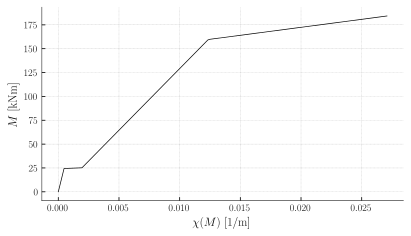

In [91]:
#| label: fig-mchi_diagramm_sv14
#| fig-cap: Momenten-Krümmungsdiagramm händisch ermittelt, definiert im positiven Bereich

M_R_num = np.float64(eq_M_R_num.rhs.evalf(4) /unit.m/unit.N)
chi_M_lambda = sp.lambdify((M, EI_I, EI_II, EI_III, M_r, M_y, M_R), eq_chi_M.rhs)
M_array = np.linspace(0,M_R_num * 2, 500)
chi_M_array = chi_M_lambda(M_array, *M_chi_params)
plt.plot(chi_M_array, M_array/1000, color='black')

# Anmerkungen hinzufügen



plt.xlabel(f'${sp.latex(chi_M)}$ [1/m]')
plt.ylabel(f'${sp.latex(M)}$ [kNm]')



plt.savefig('../images/momenten_krummung_SV14.svg')


plt.show()


#### Zustandslinien der Krümmung

Der Biegemomentenverlauf $M(x)$ als Eingabe in die Funktion der Krümmung $\chi(M)$ resultiert zu den Zustandslinie der Krümmung in @fig-chi_x_diagramm. Dargestellt sind die Krümmungsverläufe für die Biegemomentenverläufe aus @fig-m_x und @fig-m_x_versatz.

In [92]:
chi_M_versuch_2 = []
for M_x in M_x_array:
    chi_M_versuch_2.append(chi_M_lambda(M_x, *M_chi_params))

chi_M_versatz_versuch_2 = []
for M_x in M_x_array_versatz:
    chi_M_versatz_versuch_2.append(chi_M_lambda(M_x, *M_chi_params))


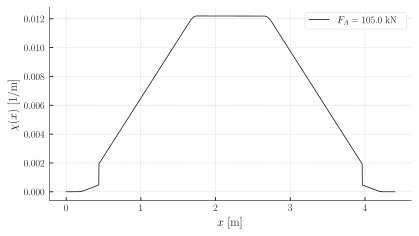

In [93]:
#| label: fig-chi_x_diagramm_sv14
#| fig-cap: Krümmungsverlauf entlang der Stabachse

plt.plot(x_array, chi_M_versuch_2[-1], color='black', label=f'$F_A =$ {Laststufen[-1]/1000} kN')
# plt.plot(x_array, chi_M_versatz_versuch_2[-1], color='darkgreen', label='Längszugkraft aus Querkraft')


plt.xlabel(f'${sp.latex(x)}$ [m]')
plt.ylabel(f'$\chi(x)$ [1/m]')
plt.legend()
plt.savefig('../images/krummungsverlauf_SV14.svg')

plt.show()


#### Punktuelle Bestimmung der Verformung

Unter Anwendung der Arbeitsgleichung kann die Verformung nach @eq-arbeitsgleichung bestimmt werden.

$$
w = \int_0^l \bar{M}(x) \cdot \frac{M(x)}{EI} d_x
$${#eq-arbeitsgleichung}

Wobei $\frac{M(x)}{EI} = \chi(x)$ gilt.

Es gilt die Zustandslinien der Krümmung multipliziert mit der Zustandslinie der Biegemomente in @fig-m_x_diagramm_virtuell des virtuellen Kräftezustands über die Stablänge zu integrieren.

In [94]:
M_x_array_bar = M_x_lamb(1,x_array)

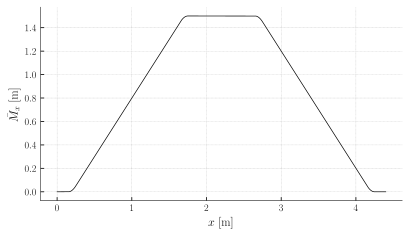

In [95]:
#| label: fig-m_x_diagramm_virtuell_sv14
#| fig-cap: Biegemomentenverlauf für den virtuellen Kräftezustand

plt.plot(x_array, M_x_array_bar, color='black')
# plt.plot(x_array, M_x_array_versatz[0], color='darkgreen', label='Längszugkraft aus Querkraft')

plt.xlabel(f'${sp.latex(x)}$ [m]')
plt.ylabel('$\\bar{M}_x$ [m]')
plt.savefig('../images/M_virtuell_SV14.svg')

plt.show()

In [96]:
w_1_m_chi = []

for i in range(0, len(M_x_array_versatz)):
    w_1_m_chi.append(np.trapz(M_x_array[0]*chi_M_versuch_2[i], x_array))
    
    
    
w_1_m_chi_versatz = []

for i in range(0, len(M_x_array_versatz)):
    w_1_m_chi_versatz.append(np.trapz(M_x_array_versatz[0]*chi_M_versatz_versuch_2[i], x_array))

Für die maximale Last beträgt die Deformation an der Stelle $w_1$ beispielsweise:

In [97]:
eq_w_1_m_chi = unit.convert_to(sp.Eq(w_1,w_1_m_chi[-1]*unit.m), unit.mm)
eq_w_1_m_chi.evalf(3)

w₁ = 36.5⋅millimeter

### Zugversteifung

Die bisherige Betrachtung beschränkt sich auf einen schlagartigen Wechsel von ungerissen zu vollständig gerissen. Dabei wird der Bereich zwischen den Rissen ebenfalls als gerissen angenommen. Mittels der Zugversteifung wird ein theoretischer Rissabstand ermittelt und zwischen den Rissen eine versteifte Wirkung zwischen Betonstahl und Beton angenommen (Verbundwirkung). Dies wird folgend auf das Versuchsbeispiel angewendet. Berücksichtigt wird dies unter dem Ansatz von Marti, beschrieben in @Spathelf2022.

Die Krümmungsdifferenez nach Marti beträgt:

In [98]:
eq_delta_chi_gamma = sp.Eq(delta_chi, sp.Mul(lamb / 2, f_ct * (1-rho_eff)/(rho_eff * E_s*(d-x_2)), evaluate=False))
eq_rho_eff = sp.Eq(rho_eff, (M_r*(d-x_2) * E_s / (f_ct * EI_II)+1-n)**-1)
eq_srm = sp.Eq(s_rm, lamb * diam_s*(1-rho_eff)/(4*rho_eff))

eq_sigma_sr0 = sp.Eq(sigma_sr0, F_z2 / A_s)
eq_w_r = sp.Eq(w_r, s_rm * (2*sigma_sr - lamb * sigma_sr0) / (2*E_s))

display(eq_delta_chi_gamma)

                λ  f_ct⋅(1 - ρ_eff)
\Delta\chi(λ) = ─⋅─────────────────
                2 Eₛ⋅ρ_eff⋅(d - x₂)

Der mechanische Bewehrungsgehalt folgt zu:

In [99]:
display(eq_rho_eff)

                   1           
ρ_eff = ───────────────────────
                 Eₛ⋅Mᵣ⋅(d - x₂)
        -n + 1 + ──────────────
                 EI__{II}⋅f_ct 

Eine Abschätzung des Rissabstands ist der folgende:

In [100]:
display(eq_srm)

      \oslashₛ⋅λ⋅(1 - ρ_eff)
sᵣₘ = ──────────────────────
             4⋅ρ_eff        

Die Rissspannung beträgt:

In [101]:
display(eq_sigma_sr0)

       F_z,2
σₛᵣ₀ = ─────
         Aₛ 

und die Rissbreiten lässt sich folgend beschreiben:

In [102]:
display(eq_w_r)

     sᵣₘ⋅(-λ⋅σₛᵣ₀ + 2⋅σₛᵣ)
wᵣ = ─────────────────────
              2⋅Eₛ        

Durch das Einsetzen der Versuchsparameter ergeben sich folgende Werte:

In [103]:
eq_delta_chi_gamma_num = unit.convert_to(eq_subs(eq_delta_chi_gamma, eq_rho_eff, eq_M_r_num, eq_EI_II_num, eq_n_num, eq_x_2_num, eq_d_num).subs(params), unit.m)
eq_rho_eff_num = eq_subs(eq_rho_eff, *Eq_list).subs(params)

display(eq_delta_chi_gamma_num.evalf(3), eq_rho_eff_num.evalf(3))
Eq_list.extend([eq_delta_chi_gamma, eq_rho_eff, eq_srm,eq_sigma_sr0, eq_w_r])


                0.000772⋅λ
\Delta\chi(λ) = ──────────
                  meter   

ρ_eff = 0.0456

In [104]:
eq_srm_num = eq_subs(eq_srm, eq_rho_eff_num).subs(params)

eq_srm_num.evalf(3)

sᵣₘ = 94.1⋅λ⋅millimeter

In [105]:
eq_chi_M_zugversteifung = sp.Eq(chi_M, sp.Piecewise((0,M<=0),(M/ (EI_I), (M > 0) & (M < eq_M_r.lhs)), (M/(EI_II)-eq_delta_chi_gamma_num.rhs.evalf(3)*unit.m, (M > eq_M_r.lhs) & (M < M_y)), (chi_M_linear.rhs , (M > M_y) & (M < M_R))))


Unter Berücksichtigung der beiden $\lambda$-Grenzwerte ist der Einfluss der Zugversteifung im Momente-Krümmungsdiagramm in @fig-mchi_diagramm_zugversteifung gezeigt.

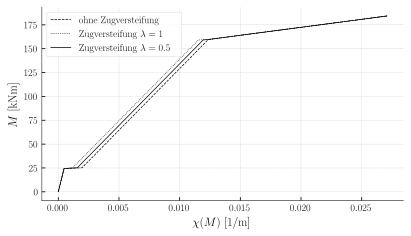

In [106]:
#| label: fig-mchi_diagramm_zugversteifung_sv14
#| fig-cap: Momenten-Krümmungsdiagramm mit Zugversteifung ergänzt

eq_chi_M_zugversteifung_lambda = sp.lambdify((M,lamb, EI_I, EI_II, EI_III, M_r, M_y, M_R), eq_chi_M_zugversteifung.rhs)

chi_M_zugversteifung_array = eq_chi_M_zugversteifung_lambda(M_array,1, *M_chi_params)
chi_M_zugversteifung_array_05 = eq_chi_M_zugversteifung_lambda(M_array,0.5, *M_chi_params)

plt.plot(chi_M_array, M_array/1000, color='black', linestyle='dashed', label='ohne Zugversteifung')
plt.plot(chi_M_zugversteifung_array, M_array/1000, color='black', linestyle='dotted', label='Zugversteifung $\lambda = 1$')
plt.plot(chi_M_zugversteifung_array_05, M_array/1000, color='black', label='Zugversteifung $\lambda = 0.5$')


plt.xlabel(f'${sp.latex(chi_M)}$ [1/m]')
plt.ylabel(f'${sp.latex(M)}$ [kNm]')
plt.legend()
plt.savefig('../images/Momenten_krummung_zugversteift_SV14.svg')

plt.show()

Es zeigt sich ein steiferes Verhalten im ungerissenen Bereich.

## Fachwerk 



In [107]:
# Specify the file path
file_path_tot = "src\models\deformation_results_FEM_tot.txt"
file_path_schubbewehrung = "src\models\deformation_results_FEM_schubbewehrung.txt"
file_path_druckstrebe = "src\models\deformation_results_FEM_druckstrebe.txt"
file_path_druckgurt = "src\models\deformation_results_FEM_druckgurt.txt"
file_path_zuggurt = "src\models\deformation_results_FEM_zuggurt.txt"


# Open the file in read mode
with open(file_path_tot, "r") as file:
    # Read each line and convert it back to an integer
    w_1_fachwerk_tot = np.array([float(line.strip()) for line in file])


# Open the file in read mode
with open(file_path_zuggurt, "r") as file:
    # Read each line and convert it back to an integer
    w_1_fachwerk_zuggurt = np.array([float(line.strip()) for line in file])


# Open the file in read mode
with open(file_path_druckgurt, "r") as file:
    # Read each line and convert it back to an integer
    w_1_fachwerk_druckgurt = np.array([float(line.strip()) for line in file])
    
# Open the file in read mode
with open(file_path_schubbewehrung, "r") as file:
    # Read each line and convert it back to an integer
    w_1_fachwerk_schubbewehrung = np.array([float(line.strip()) for line in file])

# Open the file in read mode
with open(file_path_druckstrebe, "r") as file:
    # Read each line and convert it back to an integer
    w_1_fachwerk_druckstrebe = np.array([float(line.strip()) for line in file])


Die bisherigen Analysen beschränken sich auf eine Querschnittsbetrachtung. 
Der Kraftfluss lässt sich mit einem Spannungsfeld detaillierter verfolgen. Eine Einteilung in Parallelfelder und Fächer ist in @fig-spannungsfelder_steil gezeigt. Dabei ist der Neigungswinkel maximal steil gewählt. Die Höhe der Spannungsfelder entspricht dem Hebelarm der inneren Kräfte. Grundsätzlich ist dieser abhängig von der Druckzonenhöhe und der statischen Höhe. Dies zeigte sich bereits bei der Querschnittsanalyse zwischen den Zuständen 1 bis 4. Als Vereinfachung wird eine konstante Höhe vorausgesetzt.


![Spannungsfeld mit steiler Feldneigung](../images/Spannungsfelder.svg){#fig-spannungsfelder_steil}

Durch das Zusammenfassen der Felder zu Streben resultiert das Fachwerk in @fig-fachwerk. Um aus dem Fachwerkmodell zutreffende Deformation zu ermitteln, gilt es den Pendelstäben passende Dehnsteifigkeiten zu zuordnen. 

![Fachwerk mit steiler Feldneigung](../images/Fachwerk.svg){#fig-fachwerk}

**Zuggurt:** 

Die Steifigkeit des Zuggurts resultiert aus der Querschnittsfläche der Biegebewehrung und dem Elastizitätsmodul. Dabei wird die Spannungs-Dehnungs-Beziehung gemäss @fig-stahlkennlinie hinterlegt.

**Druckgurt:** 

Die Querschnittsfläche des Druckgurts entspricht der Druckzonenhöhe multipliziert mit der Plattenstreifenbreite. Diese wird als konstant über sämtliche Stäbe des Druckgurtes angenommen. Der Elastizitätsmodul folgt aus der Kennlinie in @fig-betonkennlinie.

**Druckdiagonalen:** 

Die Breite der Druckdiagonalen entspricht der Breite des Spannungsfelds. Vereinfacht gilt dies auch für die Fächer. Die Breite Multipliziert mit der Plattenbreite resultiert zur Querschnittsfläche. Der Elastizitätsmodul folgt ebenfalls aus @fig-betonkennlinie.


**Zugstreben:** 

Die vertikalen Zugstreben bilden die Schubbewehrung ab. Die Querschnittsfläche resultiert aus der Anzahl an Schubdübeln im entsprechenden Spannungsfeld.

![Anordnung der Schubbewehrung im Fachwerk mit steiler Neigung](../images/Schubbewehrung_aufteilung.svg){#fig-schubbew_fw_steil}

Das Spannungsfeld für die gewählte Neigung umfasst zwei Stabreihen. Es ist ein linear elastisches Stoffgesetz hinterlegt.


Die Berechnung der Spannungen des Systems in @☻fig-fachwerk mit den entsprechenden Steifigkeiten führt bei der maximalen Laststufe zu einem Versagen der Schubbewehrung. Dies entspricht nicht dem Versagen im Versuchsbericht. Ein angepasstes Modell ist in @fig-spannungsfelder_flach gezeigt. Durch eine flachere Neigung der Felder lagert sich die Kraft der Schubbewehrung in die Gurtkräfte um. Die Spannungen in den Schubdübeln reduzieren sich.

![Spannungsfeld mit flacher Feldneigung](../images/Spannungsfelder_flach.svg){#fig-spannungsfelder_flach}

Die Querschnittsflächen der Druckdiagonalen und Zugstreben in @fig-fachwerk_flach ändern sich im Vergleich mit deren aus @fig-fachwerk.

![Fachwerk mit flacher Feldneigung](../images/Fachwerk_flach.svg){#fig-fachwerk_flach}

@fig-schubbew_fw_flach zeigt die Erhöhung der Querschnittsfläche der Schubbewehrung pro Strebe durch die Änderung der Feldneigung.

![Anordnung der Schubbewehrung im Fachwerk mit flacher Neigung](../images/Schubbewehrung_aufteilung_flach.svg){#fig-schubbew_fw_flach}


Die Reduktion des Neigungswinkels führt zu einem Versagen der Zugbewehrung. Das erhoffte Versagen in der Druckzone tritt nicht ein. Dazu sind die berechneten Verformungen deutlich grösser als die gemessenen im Versuch. 

Am Fachwerkmodell lassen sich die Verformungsanteile aus der Schubbewehrung, der Gurte und der Betondruckstreben ermitteln. Beispielsweise lässt sich der Anteil der Schubbewehrung durch das Setzen der Steifigkeit der übrigen Stäbe auf ein infinit grosses Mass bestimmen. Dargestellt ist dies in @fig-last_verformung_fachwerk.



{{< pagebreak >}}

## Modellvergleich

Abgeschlossen wird die Analyse des Dreipunktbiegeversuchs mit einer Gegenüberstellung der angewendeten Methoden. 

In [108]:
#Biegemomentenverlauf und Zugversteifung

##Krümmungsverlauf
chi_x_versuch_2_zugversteifung_lamba_1 = []
chi_x_versuch_2_zugversteifung_lamba_05 = []


for M_x in M_x_array:
    chi_x_versuch_2_zugversteifung_lamba_1.append(eq_chi_M_zugversteifung_lambda(M_x,1, *M_chi_params))
    chi_x_versuch_2_zugversteifung_lamba_05.append(eq_chi_M_zugversteifung_lambda(M_x,0.5, *M_chi_params))

# Verformung w1
w_1_m_chi_zugversteifung_1 = []
w_1_m_chi_zugversteifung_05 = []

for i in range(0,len(M_x_array)):
    w_1_m_chi_zugversteifung_1.append(np.trapz(M_x_array[0] * chi_x_versuch_2_zugversteifung_lamba_1[i], x_array))
    w_1_m_chi_zugversteifung_05.append(np.trapz(M_x_array[0] * chi_x_versuch_2_zugversteifung_lamba_05[i], x_array))





#Längszugkraft und Zugversteifung

##Krümmungsverlauf
chi_x_versuch_2_zugversteifung_lamba_1_versatz = []
chi_x_versuch_2_zugversteifung_lamba_05_versatz = []

for M_x in M_x_array_versatz:
    chi_x_versuch_2_zugversteifung_lamba_1_versatz.append(eq_chi_M_zugversteifung_lambda(M_x,1, *M_chi_params))
    chi_x_versuch_2_zugversteifung_lamba_05_versatz.append(eq_chi_M_zugversteifung_lambda(M_x,0.5, *M_chi_params))

## Verformung w1
w_1_m_chi_zugversteifung_1_versatz = []
w_1_m_chi_zugversteifung_05_versatz = []

for i in range(0,len(M_x_array_versatz)):
    w_1_m_chi_zugversteifung_1_versatz.append(np.trapz(M_x_array_versatz[0] * chi_x_versuch_2_zugversteifung_lamba_1_versatz[i], x_array))
    w_1_m_chi_zugversteifung_05_versatz.append(np.trapz(M_x_array_versatz[0] * chi_x_versuch_2_zugversteifung_lamba_05_versatz[i], x_array))
    
 
    


#konstante Steifigkeit
def chi_M_elastisch(M, EI):
    return M/EI


##Krümmungsverlauf
chi_x_versuch_2_konstant_gerissen = []
chi_x_versuch_2_konstant_ungerissen = []

for M_x in M_x_array:
    chi_x_versuch_2_konstant_ungerissen.append(chi_M_elastisch(M_x,np.float64(eq_EI.rhs.subs(params_plot))))
    chi_x_versuch_2_konstant_gerissen.append(chi_M_elastisch(M_x, np.float64(unit.convert_to(eq_EI_II_num.rhs, unit.m)/(unit.N*unit.m**2))))

## Momenten-Krümmungsbeziehung
chi_M_ungerissen = chi_M_elastisch(M_array, np.float64(eq_EI.rhs.subs(params_plot)))
chi_M_gerissen = chi_M_elastisch(M_array, np.float64(unit.convert_to(eq_EI_II_num.rhs, unit.m)/(unit.N*unit.m**2)))

## Verformung w1
w_1_elastisch_gerissen = []
for Last in Laststufen:
    w_1_elastisch_gerissen.append(w_x_lamb(Last, 0.11, np.float64(unit.convert_to(eq_EI_II_num.rhs, unit.m)/(unit.N*unit.m**2))))
    
## Verformung w1 Norm
w_1_norm = []
for w in w_1_elastisch_ungerissen:
    w_1_norm.append(w_1_gerissen_norm_lamb(w))
    



#konstante Steifigkeit und Längszugkraft

##Krümmungsverlauf
chi_x_versuch_2_konstant_gerissen_versatz = []
chi_x_versuch_2_konstant_ungerissen_versatz = []

for M_x in M_x_array_versatz:
    chi_x_versuch_2_konstant_ungerissen_versatz.append(chi_M_elastisch(M_x,np.float64(eq_EI.rhs.subs(params_plot))))
    chi_x_versuch_2_konstant_gerissen_versatz.append(chi_M_elastisch(M_x, np.float64(unit.convert_to(eq_EI_II_num.rhs, unit.m)/(unit.N*unit.m**2))))


## Verformung w1
w_1_elastisch_ungerissen_versatz = []
w_1_elastisch_gerissen_versatz = []

for i in range(0,len(M_x_array_versatz)):
    w_1_elastisch_ungerissen_versatz.append(np.trapz(M_x_array_versatz[0] * chi_x_versuch_2_konstant_ungerissen_versatz[i], x_array))
    w_1_elastisch_gerissen_versatz.append(np.trapz(M_x_array_versatz[0] * chi_x_versuch_2_konstant_gerissen_versatz[i], x_array))
    
## Verformung w1 Norm
w_1_norm_versatz = []
for w in w_1_elastisch_ungerissen_versatz:
    w_1_norm_versatz.append(w_1_gerissen_norm_lamb(w))    
 

 
    
#Versuch Jaeger



w_1_versuch_SV14 = [0, 
0.28571428571428825,
0.44642857142857295,
0.5000000000000027,
0.767857142857145,
1.2500000000000018,
3.3392857142857153,
5.750000000000002,
6.875000000000002,
9.178571428571432,
13.25,
16.78571428571429,
20.85714285714286,
24.28571428571429,
28.035714285714292,
31.571428571428577,
33.392857142857146,
35.160714285714285,
37.410714285714285]


F_A_versuch_SV14 = [0,
5.315436241610726,
7.087248322147644,
8.859060402684563,
11.516778523489918,
14.322147651006702,
20.375838926174495,
28.791946308724818,
33.221476510067106,
41.63758389261744,
57.583892617449656,
69.54362416107382,
78.40268456375838,
84.60402684563758,
92.57718120805369,
99.51677852348993,
102.02684563758389,
103.6510067114094,
104.53691275167785]

    


Der Vergleich im Momentenkrümmungsdiagramm @fig-mchi_diagramm_vergleich ist Belastungsunabhängig. Es zeigt den minimalen Einfluss der Zugversteifung.

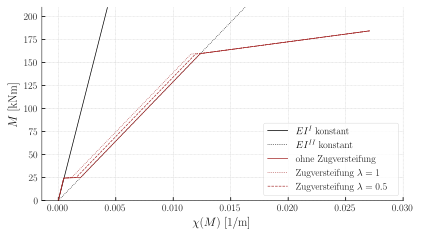

In [109]:
#| label: fig-mchi_diagramm_vergleich_sv14
#| fig-cap: Momenten-Krümmungsdiagramm der unterschiedlichen Methoden

plt.plot(chi_M_ungerissen, M_array/1000, color='black', linestyle='-', label='$EI^{I}$ konstant')
plt.plot(chi_M_gerissen, M_array/1000, color='black', linestyle='dotted', label='$EI^{II}$ konstant')


plt.plot(chi_M_array, M_array/1000, color='brown',  label='ohne Zugversteifung')
plt.plot(chi_M_zugversteifung_array, M_array/1000, color='brown', linestyle='dotted', label='Zugversteifung $\lambda = 1$')
plt.plot(chi_M_zugversteifung_array_05, M_array/1000, color='brown', linestyle='dashed',label='Zugversteifung $\lambda = 0.5$')


plt.xlabel(f'${sp.latex(chi_M)}$ [1/m]')
plt.ylabel(f'${sp.latex(M)}$ [kNm]')
plt.ylim(0,210)
plt.legend()
plt.savefig('../images/momenten_krummung_vergleich_SV14.svg')

plt.show()

Der Krümmungsverlauf bedingt einen Biegemomentenverlauf. Unterschieden wird zwischen der Berücksichtigung der Längszugkraft aus Querkraft, siehe @fig-chi_x_diagramm_vergleich und @fig-chi_x_diagramm_laengszugkraft.

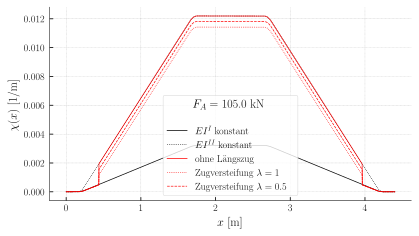

In [110]:
#| label: fig-chi_x_diagramm_vergleich_sv14
#| fig-cap: Krümmungsverlauf für die maximale Laststufe ohne Längszugkraft
    
plt.plot(x_array,chi_x_versuch_2_konstant_ungerissen[-1], color ='black', linestyle='-', label='$EI^{I}$ konstant' )
plt.plot(x_array,chi_x_versuch_2_konstant_gerissen[-1], color ='black', linestyle='dotted', label='$EI^{II}$ konstant' )



plt.plot(x_array, chi_M_versuch_2[-1], color='red', linestyle='-', label=f'ohne Längszug')
plt.plot(x_array, chi_x_versuch_2_zugversteifung_lamba_1[-1], color='red', linestyle='dotted', label=f'Zugversteifung $\lambda = 1$')
plt.plot(x_array, chi_x_versuch_2_zugversteifung_lamba_05[-1], color='red', linestyle='dashed',label=f'Zugversteifung $\lambda = 0.5$')


plt.xlabel(f'${sp.latex(x)}$ [m]')
plt.ylabel(f'$\chi(x)$ [1/m]')
plt.legend(title=f'$F_A =$ {Laststufen[-1]/1000} kN\n')
plt.savefig('../images/krummungsverlauf_zugversteift_SV14.svg')

plt.show()


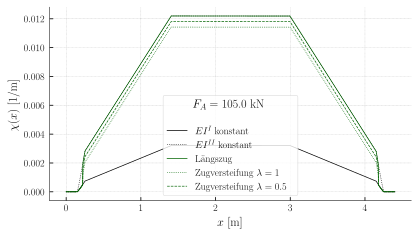

In [111]:
#| label: fig-chi_x_diagramm_laengszugkraft_sv14
#| fig-cap: Krümmungsverlauf für die maximale Laststufe mit Längszugkraft durch Querkraft


plt.plot(x_array,chi_x_versuch_2_konstant_ungerissen_versatz[-1], color ='black', linestyle='-', label='$EI^{I}$ konstant' )
plt.plot(x_array,chi_x_versuch_2_konstant_gerissen_versatz[-1], color ='black', linestyle='dotted', label='$EI^{II}$ konstant' )




plt.plot(x_array, chi_M_versatz_versuch_2[-1], color='darkgreen', linestyle='-', label='Längszug')
plt.plot(x_array, chi_x_versuch_2_zugversteifung_lamba_1_versatz[-1], color='darkgreen', linestyle='dotted', label=f'Zugversteifung $\lambda = 1$')
plt.plot(x_array, chi_x_versuch_2_zugversteifung_lamba_05_versatz[-1], color='darkgreen', linestyle='dashed',label=f'Zugversteifung $\lambda = 0.5$')

plt.xlabel(f'${sp.latex(x)}$ [m]')
plt.ylabel(f'$\chi(x)$ [1/m]')
plt.legend(title=f'$F_A =$ {Laststufen[-1]/1000} kN\n')
plt.savefig('../images/krummungsverlauf_zugversteift_laengszugkraft_SV14.svg')

plt.show()


Der Vergleich der Krümmungsverläufe zeigt, dass mit einer konstanten Biegesteifigkeit im Bereich des Fliessens signifikante unterschiede zum verfeinerten Momenten-Krümmungsdiagramm entstehen.

In [112]:
#| label: fig-last_verformung_sv14
#| fig-cap: Last-Verformungsdiagramm bei der Krafteinleitung $F_A$
def plot_vergleich(border=False, querkraft=False):
    

    if querkraft ==False:
        plt.plot(np.array(w_1_elastisch_ungerissen)*1000, Laststufen/1000,color='black',linestyle='-', label='$EI^{I}$ konstant')
        plt.plot(np.array(w_1_elastisch_gerissen)*1000, Laststufen/1000,color='black',linestyle='dotted', label='$EI^{II}$ konstant')
        plt.plot(np.array(w_1_norm)*1000, Laststufen/1000, color='black',linestyle='dashed', label = 'Abschätzung Norm')
    

        plt.plot(np.array(w_1_m_chi)*1000, Laststufen/1000,color='red', label='Querkraft vernachlässigt')
        plt.plot(np.array(w_1_m_chi_zugversteifung_1)*1000, Laststufen/1000,color='red', linestyle='dotted', label='Zugversteifung $\lambda = 1$')
        plt.plot(np.array(w_1_m_chi_zugversteifung_05)*1000, Laststufen/1000,color='red', linestyle='dashed', label='Zugversteifung $\lambda = 0.5$')

    if querkraft== True:
        
        plt.plot(np.array(w_1_elastisch_ungerissen_versatz)*1000, Laststufen/1000,color='black',linestyle='-', label='$EI^{I}$ konstant')
        plt.plot(np.array(w_1_elastisch_gerissen_versatz)*1000, Laststufen/1000,color='black',linestyle='dotted', label='$EI^{II}$ konstant')
        plt.plot(np.array(w_1_norm_versatz)*1000, Laststufen/1000, color='black',linestyle='dashed', label = 'Abschätzung Norm')
    
        plt.plot(np.array(w_1_m_chi_versatz)*1000, Laststufen/1000, color='darkgreen', label='Längszugkraft')
        plt.plot(np.array(w_1_m_chi_zugversteifung_1_versatz)*1000, Laststufen/1000,color='darkgreen', linestyle='dotted', label='Zugversteifung $\lambda = 1$')
        plt.plot(np.array(w_1_m_chi_zugversteifung_05_versatz)*1000, Laststufen/1000,color='darkgreen', linestyle='dashed', label='Zugversteifung $\lambda = 0.5$')


    
    plt.plot(np.array(w_1_versuch_SV14)-w_1_versuch_SV14[0], F_A_versuch_SV14, color='blue', linestyle='-', label='Versuch A3 2.Anordnung')
    
    if border ==True:
        plt.xlim(0,max(np.array(w_1_m_chi_versatz)*1000))

    plt.xlabel(f'${sp.latex(w_1)}$ [mm]')
    plt.ylabel(f'${sp.latex(F_A)}$ [kN]')
    plt.legend()
    plt.savefig('../images/durchbiegung_vergleich_SV14.svg')

    plt.show()


Aussagekräfte sind vor allem die Last-Verformungsdiagramme in @fig-last_verformung_vergleich und @fig-last_verformung_laengszug. Diese unterscheiden sich in der Berücksichtigung der Längszugkraft aus Querkraft. 

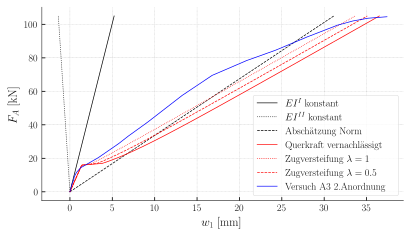

In [113]:
#| label: fig-last_verformung_vergleich_sv14
#| fig-cap: Last-Verformungsdiagramm bei der Krafteinleitung $F_A$ 

plot_vergleich()

Es zeigt sich, dass mit einer konstanten ungerissenen Biegesteifigkeit die Verformungen nicht zufriedenstellen abbildbar sind.  Vor allem im Bereich des Fliessens ist das Modell grundsätzlich nicht mehr zielführend anwendbar. 

Mit einer konstanten gerissenen Biegesteifigkeit nähert man sich den Versuchsergebnissen an. Auch hier ist klar der Bereich des Fliessens des Betonstahls nicht abgedeckt. Für eine Bemessung ist dies jedoch zutreffend, da die Bauteile grundsätzlich nicht bis in den Fliessbereich zu belasten sind.

Die Darstellung der Normabschätzung zeigt eine konservative Abschätzung der Verformungen. Dies führt grundsätzlich zu einer Überbemessung. Die Anwendung des Berechnungsalgorithmus ist jedoch simpel und somit eine solide Grundabschätzung.

Bei der Berücksichtigung des verfeinerten Momenten-Krümmungsdiagramms in rot dargestellt, lässt sich das Verformungsverhalten des Versuchs annähernd abbilden. Das Modell bildet ein zu steifes Verhalten ab. Die Zugversteifung wirkt der Modellgenauigkeit entgegen.

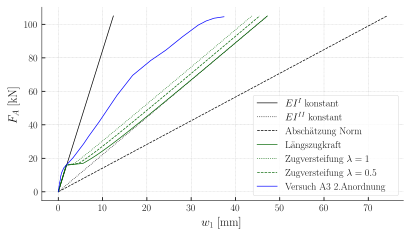

In [114]:
#| label: fig-last_verformung_laengszug_sv14
#| fig-cap: Last-Verformungsdiagramm bei der Krafteinleitung $F_A$ mit Längszugkraft aus Querkraft

plot_vergleich(querkraft=True)

Die @fig-last_verformung_laengszug zeigt sämtliche Berechnungsmethoden unter Berücksichtung der Längszugkraft aus Querkraft. Es zeigt sich deutlich, dass das Berechnungsmodell mit der Zugversteifung den Versuchsverlauf zufriedenstellend abbildet. Lediglich Abweichungen im höchstlastbereich sind vorhanden. 

Die Normabschätzung zeigt deutliche Abweichungen zu den gemessenen Verformungen. Zwar liegen diese auf der sicheren Seite, sind jedoch äusserst konservativ.

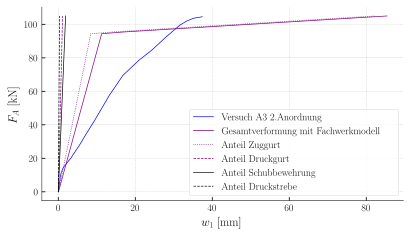

In [115]:
#| label: fig-last_verformung_fachwerk_sv14
#| fig-cap: Last-Verformungsdiagramm bei der Krafteinleitung $F_A$ mittels Fachwerkmodell
    


plt.plot(np.array(w_1_versuch_SV14)-w_1_versuch_SV14[0], F_A_versuch_SV14, color='blue', linestyle='-', label='Versuch A3 2.Anordnung')
plt.plot(np.array(w_1_fachwerk_tot)*1000, Laststufen/1000, color='purple',linestyle='-', label = 'Gesamtverformung mit Fachwerkmodell')
plt.plot(np.array(w_1_fachwerk_zuggurt)*1000, Laststufen/1000, color='purple',linestyle='dotted', label = 'Anteil Zuggurt')
plt.plot(np.array(w_1_fachwerk_druckgurt)*1000, Laststufen/1000, color='purple',linestyle='dashed', label = 'Anteil Druckgurt')
plt.plot(np.array(w_1_fachwerk_schubbewehrung)*1000, Laststufen/1000, color='black',linestyle='-', label = 'Anteil Schubbewehrung')
plt.plot(np.array(w_1_fachwerk_druckstrebe)*1000, Laststufen/1000, color='black',linestyle='dashed', label = 'Anteil Druckstrebe')


plt.xlabel(f'${sp.latex(w_1)}$ [mm]')
plt.ylabel(f'${sp.latex(F_A)}$ [kN]')

# plt.xlim(0,max(np.array(w_1_versuch_A3V2)))

plt.legend()
plt.savefig('../images/durchbiegung_vergleich_fachwerk_SV14.svg')

plt.show()




Das Fachwerkmodell beschreibt den Verlauf ausreichend präzise. Die maximale Deformation mit der rechnerisch ermittelten Höhe, sprich innerem Hebelarm aus der Querschnittsnalyse überschiesst das Ziel bei Weitem. Das Fachwerkmodell reagiert äusserst sensitiv auf die gewählte Höhe. Der Verformungsverlauf lässt sich mit einer Fachwerkshöhe von $160mm$ präzise abbilden. Ohne Kenntnisse der Versuchsresultate wäre jedoch eine präzise Bestimmung der Verformung im Bereich des Fliessens der Zugbewehrung nicht möglich.
